# The problem: How to efficiently control an electric motor

"The task of the controller is to achieve a desired torque at the wheels of the car by controlling the currents of the electric motor.With machine learning modeling techniques, accurate models describing the behavior can be extracted from measurement data and then used by the controller."

https://www.kaggle.com/datasets/hankelea/system-identification-of-an-electric-motor

<img src="controller_inverter_motor.png" />

### Model Predictive Control (MPC)

The controller can regulate the motor currents by selecting appropriate elementary vectors.

1) Measurement of id, iq, ε at time point k
   
2) Prediction of the currents at k + 1 for the different elementary vectors that can be applied
3) Selection of the elementary vector that brings both
currents as close as possible to the set points
1) Apply the selected elementary vector for one cycle (here between k and k + 1)
2) Repeat steps 1-4 for the next cycle beginning at k + 1


### Elementary Vector(Inverter Switching States)

<img src="inverter_switching_states.png">

### Targeted Set Points

Again our targets are the d and q currents at time k + 1.

"PID systems automatically apply accurate and responsive correction to a control function. An everyday example is the cruise control on a car, where ascending a hill would lower speed if constant engine power were applied. The controller's PID algorithm restores the measured speed to the desired speed with minimal delay and overshoot by increasing the power output of the engine in a controlled manner."

https://en.wikipedia.org/wiki/Proportional%E2%80%93integral%E2%80%93derivative_controller

<img src="targeted_set_points.png"/>

### Model Predictive Control and Machine Learning

"An important challenge in the design and real-time implementation of MPC is having a accurate predictive model that also does not require excessive real-time computation. "

https://www.sciencedirect.com/science/article/abs/pii/S0952197623000623

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
import statsmodels.formula.api as smf
from sklearn import model_selection, metrics
from sklearn.linear_model import LinearRegression

In [3]:
pd.set_option('display.max_columns',200)
pd.set_option('display.max_rows',500)

In [4]:
#https://www.kaggle.com/datasets/hankelea/system-identification-of-an-electric-motor
original_data = pd.read_csv("./Dataset_Electric_Motor.csv")

In [5]:
#electric_motor_df = original_data.copy() #save ram
electric_motor_df = original_data.iloc[::100,:] #reduce dataset while in development
electric_motor_df.head(5)

,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1
0,-81.45802,229.52930,2.240254,5,6,-105.73820,167.36170
100,-101.20220,194.92640,2.752704,3,6,-48.62930,159.77730
200,-65.31933,62.02916,2.728086,5,6,-95.14313,54.85019
300,-155.71220,85.02038,-0.433627,3,4,-183.91430,98.38583
400,-168.86510,67.30013,-0.083969,1,7,-160.16250,64.40960


# Explore Data

In [6]:
electric_motor_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 409633 entries, 0 to 40963200
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype  
---  ------     --------------   -----  
 0   id_k       409633 non-null  float64
 1   iq_k       409633 non-null  float64
 2   epsilon_k  409633 non-null  float64
 3   n_k        409633 non-null  int64  
 4   n_1k       409633 non-null  int64  
 5   id_k1      409633 non-null  float64
 6   iq_k1      409633 non-null  float64
dtypes: float64(5), int64(2)
memory usage: 21.9 MB


In [7]:
electric_motor_df.describe().T

,count,mean,std,min,25%,50%,75%,max
id_k,409633.0,-99.690859,61.269943,-239.997600,-147.242400,-94.142900,-48.027680,-0.000709
iq_k,409633.0,93.468820,59.266560,0.000669,44.143610,86.428790,138.505200,239.987000
epsilon_k,409633.0,0.012900,1.808286,-3.141590,-1.548557,0.034533,1.583191,3.141574
n_k,409633.0,3.789255,2.079335,1.000000,2.000000,4.000000,6.000000,7.000000
n_1k,409633.0,3.774466,2.078105,1.000000,2.000000,4.000000,6.000000,7.000000
id_k1,409633.0,-98.893393,64.397540,-283.511300,-148.004900,-94.370770,-47.915370,66.211960
iq_k1,409633.0,94.710610,61.688302,-9.395191,44.149770,86.832340,139.339400,330.474700


In [8]:
top_id_k1 = electric_motor_df['id_k1'].nlargest(5)
top_iq_k1 = electric_motor_df['iq_k1'].nlargest(5)
print(top_id_k1)
print(top_iq_k1)

38604800    66.21196
3598000     65.31663
23411500    64.87813
27223200    62.86394
20254400    61.06855
Name: id_k1, dtype: float64
18999700    330.4747
9040800     329.0872
5307200     328.4417
36918400    328.2273
9619800     328.0815
Name: iq_k1, dtype: float64


In [9]:
electric_motor_df.isna().sum()

id_k         0
iq_k         0
epsilon_k    0
n_k          0
n_1k         0
id_k1        0
iq_k1        0
dtype: int64

In [10]:
corr_table = electric_motor_df.corr()

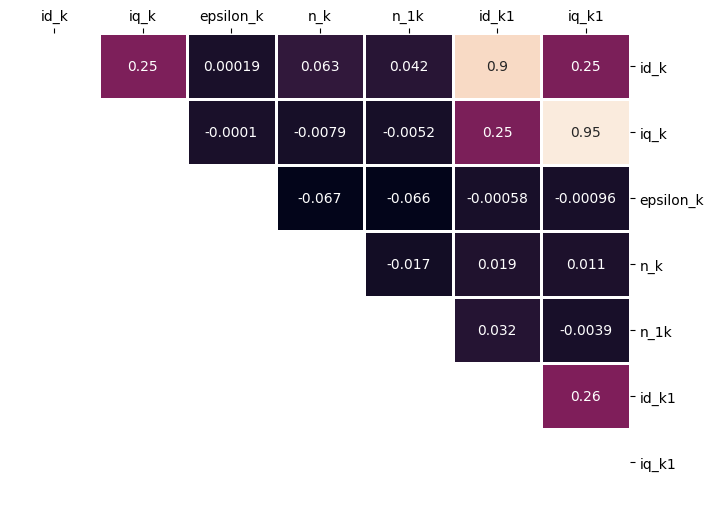

In [11]:
plt.figure(figsize = (8,6))
heat_map = sns.heatmap(data=corr_table,\
                        mask =  np.tri(N=corr_table.shape[0],M=corr_table.shape[1]),\
                        annot=True,linewidth=.75, cbar=False)
heat_map.xaxis.tick_top()
heat_map.yaxis.tick_right()
heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)
plt.show()

In [12]:
sample_df = electric_motor_df.iloc[::100,:]

In [13]:
print(sample_df.shape)
print(sample_df.columns)

(4097, 7)
Index(['id_k', 'iq_k', 'epsilon_k', 'n_k', 'n_1k', 'id_k1', 'iq_k1'], dtype='object')


In [14]:
# plt.figure(figsize = (8,6))
# scatter_id = sns.scatterplot(data=sample_df, \
#                             y=sample_df["id_k1"], \
#                             x="id_k") 
# plt.show()

In [15]:
# plt.figure(figsize = (8,6))
# scatter_id = sns.scatterplot(data=sample_df, \
#                             y=sample_df["iq_k1"], \
#                             x="iq_k") 
# plt.show()

#  Simple Linear Regression - Baseline

- Predict based only on current at time k (id_k, iq_k)
- Fit model on training data and test accuracy on test data


<img src="Simple_Linear_Regression.png">

In [16]:
X = electric_motor_df.iloc[:,:-2]
print(X.shape), print(X.columns), print(X.head(3))

(409633, 5)
Index(['id_k', 'iq_k', 'epsilon_k', 'n_k', 'n_1k'], dtype='object')
          id_k       iq_k  epsilon_k  n_k  n_1k
0    -81.45802  229.52930   2.240254    5     6
100 -101.20220  194.92640   2.752704    3     6
200  -65.31933   62.02916   2.728086    5     6


(None, None, None)

In [17]:
y_i_d = electric_motor_df['id_k1']
y_i_q = electric_motor_df['iq_k1']
print(y_i_d.shape), print(y_i_q.shape)

(409633,)
(409633,)


(None, None)

In [18]:
X_id_train, X_id_test, y_id_train,y_id_test =\
      model_selection.train_test_split(X['id_k'],y_i_d,\
                                       train_size = 0.8,\
                                       random_state=1)


In [19]:
test_xid = np.reshape(X_id_train,(-1,1))
print(test_xid.shape)

(327706, 1)


In [20]:
X_id_train = np.reshape(X_id_train,(-1,1))
X_id_test = np.reshape(X_id_test,(-1,1))

# fit
model_id = LinearRegression().fit(X_id_train, y_id_train)
train_r2 = model_id.score(X_id_train, y_id_train)
coefficient_id_k = model_id.coef_
intercept_id_k = model_id.intercept_

print(f"train R^2: {train_r2} | id_k1 = {coefficient_id_k}*(id_k) {intercept_id_k}")

# predict
pred_id = model_id.predict(X_id_test)
test_r2 = model_id.score(X_id_test,y_id_test)

#evaluate
model_id_mse = metrics.mean_squared_error(y_id_test,pred_id)
model_id_mae = metrics.mean_absolute_error(y_id_test,pred_id)

print(f"test R^2: {test_r2} | Mean Squared Error: {model_id_mse} A²")
print(f"Mean Absolute Error: {model_id_mae} A")


train R^2: 0.8125184777166041 | id_k1 = [0.94711151]*(id_k) -4.456402860146184
test R^2: 0.8111567513726974 | Mean Squared Error: 782.3340625879628 A²
Mean Absolute Error: 23.341855861573986 A


In [21]:
X_iq_train, X_iq_test, y_iq_train,y_iq_test =\
      model_selection.train_test_split(X['iq_k'],y_i_q,random_state=1)

In [22]:
X_iq_train = np.reshape(X_iq_train,(-1,1))
X_iq_test = np.reshape(X_iq_test,(-1,1))

# fit
model_iq = LinearRegression().fit(X_iq_train, y_iq_train)
train_r2_iq = model_id.score(X_id_train, y_id_train)
coefficient_iq_k = model_iq.coef_
intercept_iq_k = model_iq.intercept_

print(f"train R^2: {train_r2_iq} | iq_k1 = {coefficient_iq_k}*(id_k) + {intercept_iq_k}")

# predict
pred_iq = model_id.predict(X_iq_test)
test_r2_iq = model_id.score(X_iq_test,y_iq_test)

#evaluate
model_iq_mse = metrics.mean_squared_error(y_iq_test,pred_iq)
model_iq_mae = metrics.mean_absolute_error(y_iq_test,pred_iq)

print(f"test R^2: {test_r2_iq} | Mean Squared Error: {model_iq_mse} A²")
print(f"Mean Absolute Error: {model_iq_mae} A")

train R^2: 0.8125184777166041 | iq_k1 = [0.98470837]*(id_k) + 2.653441542337788
test R^2: 0.8634602582884852 | Mean Squared Error: 518.7803690981501 A²
Mean Absolute Error: 16.58169431626945 A


# Cost Function

<img src="cost_function.png"/>

Considering ed,k+1,j and eq,k+1,j as elements of an error vector for each sample j, the cost function represents the root mean square of this error vector (RMSE) regarding the m samples used for the training of the respective model.

In [23]:
rmse_simple_linear_regression = np.sqrt(model_id_mse + model_iq_mse)
print("Test data RMSE: ", rmse_simple_linear_regression)

Test data RMSE:  36.07096383084479


# Model A - Multiple Linear Regression

- Use all available inputs for target prediction

<img src="./Model_A_no_feature_eng.png"/>

In [24]:
model_A_iq = LinearRegression()
model_A_id = LinearRegression()

models_A_v1 = [{"model":model_A_iq,
             "features": X,
             "target": y_i_q},
             {"model":model_A_id,
             "features": X,
             "target": y_i_d}]

In [25]:
# Evaluate Models

def evaluate_model(model,X_train, X_test, y_train, y_test ):
    # train
    trained_model = model.fit(X_train, y_train)
    train_r2 = trained_model.score(X_train,y_train)
    coefficients = trained_model.coef_
    intercept = trained_model.intercept_

    print(f"train R^2: {train_r2}\ncoefficients: {coefficients}\nIntercept:{intercept}")
     # TODO print the equation
    # equation = " + ".join([f"({coeff:.2f})*{feature}" for coeff, feature in zip(coefficients, X_train.columns)])
    # equation = f"y = {equation} + ({intercept:.2f})"
    # print("Equation:", equation)
    
    #predict
    predictions = trained_model.predict(X_test)
    test_r2 = trained_model.score(X_test,y_test)
    
    #evaluate
    test_MSE = metrics.mean_squared_error(y_test, predictions)
    test_MAE = metrics.mean_absolute_error(y_test, predictions)

    print(f"test R^2: {test_r2}")
    print(f"Mean Squared Error: {test_MSE} A²")
    print(f"Mean Absolute Error: {test_MAE} A")

    return test_MSE

In [26]:
model_A_v1_scores = []
for m in models_A_v1:
    X_train,X_test,y_train,y_test =\
          model_selection.train_test_split(m['features'],m["target"],\
                                        train_size=0.8, random_state=1)
    model_mse = \
    evaluate_model(model = m["model"],\
                X_train = X_train, \
                X_test = X_test,\
                y_train = y_train,\
                 y_test = y_test)
    model_A_v1_scores.append(model_mse)
    print("*"*20)

print("*"*20)
print(model_A_v1_scores)


train R^2: 0.895617674764354
coefficients: [0.01048188 0.98239054 0.02013731 0.51577358 0.02826183]
Intercept:1.874106248416993
test R^2: 0.8956520905705636
Mean Squared Error: 395.5499242907745 A²
Mean Absolute Error: 13.865145136630213 A
********************
train R^2: 0.8144130305862534
coefficients: [ 0.94469347  0.02137611 -0.1295853  -1.18679767 -0.21448597]
Intercept:-1.3860126554083934
test R^2: 0.8130775156332875
Mean Squared Error: 774.3767788715248 A²
Mean Absolute Error: 22.725988629426848 A
********************
********************
[395.5499242907745, 774.3767788715248]


In [27]:
model_A_v1_test_RMSE = np.sqrt(sum(model_A_v1_scores))
print(f"Model A v1 test data RMSE: {model_A_v1_test_RMSE:.2f}")

Model A v1 test data RMSE: 34.20


# Feature Engineering

In [28]:
sample_df2 = electric_motor_df.sample(frac=0.05)
sample_df2.head(3)

,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1
35048000,-39.46336,158.8786,-1.089881,4,3,-55.51050,113.7749
32237400,-97.33363,194.8497,-2.018412,7,1,-138.98490,190.6440
34812500,-41.24951,239.5248,-2.859590,1,5,-26.65189,233.4417


## Intuition for Future Models

### Model B - Distribution Plots
- Seperate model to predict dq currents based on current switch state vector n_k
<img src="ModelB.png">

In [29]:
# group_by_column = 'n_k'
# columns_to_analyze = [col for col in sample_df2.columns if col != 'n_k']
# figure, axs = plt.subplots(nrows=7, ncols=len(columns_to_analyze), figsize=(10, 10))

# # sns.set(font_scale=2)
# for k, group in sample_df2.groupby('n_k'):
#     for i, col in enumerate(columns_to_analyze):
#         ax = axs[k-1, i]  # Get the current axis
#         sns.histplot(data=group, x=col, ax=ax)
#         ax.set(ylabel='')
        
        
#         if i == 0:
#             ax.set_ylabel(f'n_k = {k}')  # Set y-label for each row
        
#         # if k == len(axs) - 1:
#         #     ax.set_xlabel(col)  # Set x-label for the last row

#         ax.set_xticklabels([])
#         ax.set_yticklabels([])

# plt.tight_layout()

- Notice when at n_k =1 likely the previous elementary vector state was n_1k.
- For some elementary vectors, n_k, the rotor angle epsilon_k either follows a unimodal or bimodal distribution.
- The distribution plots above will serve as the intuition behind model B.
- What if we not only group by n_k but also the previous elementary vector n_1k?
  - So a state change from n_1k to n_k. This is represented by the state change column created above.
  - 49 possible state changes. So 49 model but fewer features. Just the previous current and tje rotation angle of motor.

In [30]:
# for k, group in sample_df2.groupby('n_k'):
#     group_corr_table = group.corr()
#     plt.figure(figsize=(8, 6))
#     group_heat_map = sns.heatmap(data=group_corr_table,
#                                  mask=np.tri(N=group_corr_table.shape[0], M=group_corr_table.shape[1]),
#                                  annot=True, linewidth=.75, cbar=False)
#     group_heat_map.xaxis.tick_top()
#     group_heat_map.yaxis.tick_right()
#     group_heat_map.set_yticklabels(group_heat_map.get_yticklabels(), rotation=0)
#     plt.title(f'Heat Map for Group n_k = {k}')
#     plt.show()

### Model C - Distribution Plots
- A model based on how switching state change from time k - 1 to time k
- Switch state vector at time k-1 :  n_1k 
- Switch state vector at time k :  n_k 
- Therefore a model for each state change. For example 1 -> 1 is a seperate model from 2 -> 5
  
<img src="ModelC.png">

In [31]:
def elementary_vector_change(df_subset):
    new_n_1k = df_subset["n_1k"].astype(str)
    new_n_k = df_subset["n_k"].astype(str)
    return new_n_1k + '-->' + new_n_k

sample_df2['state_change'] = sample_df2[["n_1k","n_k"]].\
    apply(elementary_vector_change,axis=1)

print(sample_df2.head(5))

print(sample_df2['state_change'].nunique())
print(sample_df2['state_change'].value_counts(normalize=True)[:10])

               id_k       iq_k  epsilon_k  n_k  n_1k      id_k1     iq_k1  \
35048000  -39.46336  158.87860  -1.089881    4     3  -55.51050  113.7749   
32237400  -97.33363  194.84970  -2.018412    7     1 -138.98490  190.6440   
34812500  -41.24951  239.52480  -2.859590    1     5  -26.65189  233.4417   
32450500 -132.53620   79.22711   2.129691    2     7 -145.62540  101.6299   
14493900 -123.15060  120.81270   1.683108    6     1 -155.90780  106.4617   

         state_change  
35048000        3-->4  
32237400        1-->7  
34812500        5-->1  
32450500        7-->2  
14493900        1-->6  
49
state_change
1-->1    0.055463
7-->2    0.033151
6-->3    0.031540
5-->4    0.031052
4-->5    0.030270
3-->6    0.029733
2-->7    0.029685
1-->7    0.027097
6-->1    0.026804
1-->4    0.026706
Name: proportion, dtype: float64


In [32]:
unique_state_changes = sample_df2['state_change'].unique()
state_change_to_integer = {state_change: idx for idx, state_change in enumerate(unique_state_changes)}
# print(state_change_to_integer)
sample_df2['state_integer'] = sample_df2['state_change'].map(state_change_to_integer)

In [33]:
sample_df2[(sample_df2['n_k'] == 1) & (sample_df2['n_1k']==1)].head(10)

,id_k,iq_k,epsilon_k,n_k,n_1k,id_k1,iq_k1,state_change,state_integer
38765800,-152.27360,146.10700,0.592049,1,1,-141.038900,142.896800,1-->1,5
3087600,-117.82380,94.56107,0.975939,1,1,-108.896500,92.639370,1-->1,5
37358800,-102.32820,141.80480,1.317220,1,1,-92.548290,139.244600,1-->1,5
38238100,-17.55254,211.58110,-2.278740,1,1,-8.053072,206.416000,1-->1,5
5084100,-130.23660,194.20220,-0.581025,1,1,-118.648800,190.351000,1-->1,5
3888500,-142.21410,91.67892,2.758992,1,1,-132.445800,90.737820,1-->1,5
31345800,-158.88940,65.94147,1.218621,1,1,-151.082400,64.731950,1-->1,5
13433400,-133.56960,56.05552,-0.985133,1,1,-127.578800,56.043960,1-->1,5
3172400,-220.84280,41.51725,1.808604,1,1,-215.047000,40.504910,1-->1,5
2040100,-54.37877,7.96130,-2.581779,1,1,-53.129110,7.615357,1-->1,5


In [34]:
# import matplotlib.gridspec as gridspec

# group_by_column = 'state_change'
# columns_model_C = [col for col in sample_df2.columns if col not in ('n_k','n_1k','state_change','state_integer')]
# print(columns_model_C)

# # Calculate the height of each subplot
# subplot_height = 2  # Adjust this value as needed

# # Create the figure and subplots with adjusted height
# figure = plt.figure(figsize=(20, len(state_change_to_integer) * subplot_height))
# gs = gridspec.GridSpec(len(state_change_to_integer),\
#                             len(columns_model_C), figure=figure,\
#                             hspace=0.5)  # hspace adjusts vertical spacing

# for state, group in sample_df2.groupby('state_change'):
#     for i, col in enumerate(columns_model_C):
#         ax = figure.add_subplot(gs[state_change_to_integer[state], i])
#         sns.histplot(data=group, x=col, ax=ax)
#         ax.set(ylabel='')

#         if i == 0:
#             ax.set_ylabel(f'{state_change_to_integer[state]}: {state}')  # Set y-label for each row

#         ax.set_xticklabels([])
#         ax.set_yticklabels([])

# plt.tight_layout()
# plt.show()

### New Features
- cos(motor angle) to make continuous
- For model B: one hot encode switch state vectors n_1k and n_k
- for Model C: one hot current switch state. Where state = tuple(n_1k, n_1k)
- Future TODO: vector norm 
- Note:
  - Typically want to apply transformations for train/test seperately.
  - Here I am transforming the data before train/test split
  - Will apply same transformations to both train/test
  - But if standardized the data would want to fit() on train data and transform on test()
  - https://stackoverflow.com/questions/55525195/do-i-have-to-do-one-hot-encoding-separately-for-train-and-test-dataset

In [35]:
X['epsilon_k'] = X['epsilon_k'].apply(lambda x: np.cos(x))
print(X.head(3))
print(X.shape)

          id_k       iq_k  epsilon_k  n_k  n_1k
0    -81.45802  229.52930  -0.620561    5     6
100 -101.20220  194.92640  -0.925331    3     6
200  -65.31933   62.02916  -0.915717    5     6
(409633, 5)


In [36]:
from sklearn.preprocessing import OneHotEncoder
# data to encode
input_df = X[['n_k','n_1k']]
# encode
encoder1 = OneHotEncoder(handle_unknown="ignore",sparse_output=False) #Test drop='first'
encoded_df1 = pd.DataFrame(encoder1.fit_transform(input_df))
# preserve index
encoded_df1.index = input_df.index
# descriptive column names
new_feature_names = encoder1.get_feature_names_out(input_df.columns.values)
encoded_df1.columns = new_feature_names
encoded_df1.columns = encoded_df1.columns.astype(str)


In [37]:
print(new_feature_names)

['n_k_1' 'n_k_2' 'n_k_3' 'n_k_4' 'n_k_5' 'n_k_6' 'n_k_7' 'n_1k_1' 'n_1k_2'
 'n_1k_3' 'n_1k_4' 'n_1k_5' 'n_1k_6' 'n_1k_7']


In [38]:
X = pd.concat([X,encoded_df1],axis=1)

In [39]:
# create a state feature
def create_state_tuple(row):
    return tuple([int(row['n_1k']),int(row['n_k'])])

X['state'] = X.apply(create_state_tuple,axis=1)

In [40]:
encoded_state_df = pd.get_dummies(X['state'], prefix='state', dummy_na=False)

In [41]:
print(encoded_state_df.columns)

Index(['state_(1, 1)', 'state_(1, 2)', 'state_(1, 3)', 'state_(1, 4)',
       'state_(1, 5)', 'state_(1, 6)', 'state_(1, 7)', 'state_(2, 1)',
       'state_(2, 2)', 'state_(2, 3)', 'state_(2, 4)', 'state_(2, 5)',
       'state_(2, 6)', 'state_(2, 7)', 'state_(3, 1)', 'state_(3, 2)',
       'state_(3, 3)', 'state_(3, 4)', 'state_(3, 5)', 'state_(3, 6)',
       'state_(3, 7)', 'state_(4, 1)', 'state_(4, 2)', 'state_(4, 3)',
       'state_(4, 4)', 'state_(4, 5)', 'state_(4, 6)', 'state_(4, 7)',
       'state_(5, 1)', 'state_(5, 2)', 'state_(5, 3)', 'state_(5, 4)',
       'state_(5, 5)', 'state_(5, 6)', 'state_(5, 7)', 'state_(6, 1)',
       'state_(6, 2)', 'state_(6, 3)', 'state_(6, 4)', 'state_(6, 5)',
       'state_(6, 6)', 'state_(6, 7)', 'state_(7, 1)', 'state_(7, 2)',
       'state_(7, 3)', 'state_(7, 4)', 'state_(7, 5)', 'state_(7, 6)',
       'state_(7, 7)'],
      dtype='object')


In [42]:
encoded_state_df = encoded_state_df.astype(int)

In [43]:
X = pd.concat([X,encoded_state_df],axis=1)

In [44]:
X.head()

,id_k,iq_k,epsilon_k,n_k,n_1k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,state,"state_(1, 1)","state_(1, 2)","state_(1, 3)","state_(1, 4)","state_(1, 5)","state_(1, 6)","state_(1, 7)","state_(2, 1)","state_(2, 2)","state_(2, 3)","state_(2, 4)","state_(2, 5)","state_(2, 6)","state_(2, 7)","state_(3, 1)","state_(3, 2)","state_(3, 3)","state_(3, 4)","state_(3, 5)","state_(3, 6)","state_(3, 7)","state_(4, 1)","state_(4, 2)","state_(4, 3)","state_(4, 4)","state_(4, 5)","state_(4, 6)","state_(4, 7)","state_(5, 1)","state_(5, 2)","state_(5, 3)","state_(5, 4)","state_(5, 5)","state_(5, 6)","state_(5, 7)","state_(6, 1)","state_(6, 2)","state_(6, 3)","state_(6, 4)","state_(6, 5)","state_(6, 6)","state_(6, 7)","state_(7, 1)","state_(7, 2)","state_(7, 3)","state_(7, 4)","state_(7, 5)","state_(7, 6)","state_(7, 7)"
0,-81.45802,229.52930,-0.620561,5,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(6, 5)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
100,-101.20220,194.92640,-0.925331,3,6,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(6, 3)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
200,-65.31933,62.02916,-0.915717,5,6,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,"(6, 5)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
300,-155.71220,85.02038,0.907448,3,4,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,"(4, 3)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400,-168.86510,67.30013,0.996477,1,7,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,"(7, 1)",0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [45]:
print(X.columns)

Index(['id_k', 'iq_k', 'epsilon_k', 'n_k', 'n_1k', 'n_k_1', 'n_k_2', 'n_k_3',
       'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7', 'n_1k_1', 'n_1k_2', 'n_1k_3',
       'n_1k_4', 'n_1k_5', 'n_1k_6', 'n_1k_7', 'state', 'state_(1, 1)',
       'state_(1, 2)', 'state_(1, 3)', 'state_(1, 4)', 'state_(1, 5)',
       'state_(1, 6)', 'state_(1, 7)', 'state_(2, 1)', 'state_(2, 2)',
       'state_(2, 3)', 'state_(2, 4)', 'state_(2, 5)', 'state_(2, 6)',
       'state_(2, 7)', 'state_(3, 1)', 'state_(3, 2)', 'state_(3, 3)',
       'state_(3, 4)', 'state_(3, 5)', 'state_(3, 6)', 'state_(3, 7)',
       'state_(4, 1)', 'state_(4, 2)', 'state_(4, 3)', 'state_(4, 4)',
       'state_(4, 5)', 'state_(4, 6)', 'state_(4, 7)', 'state_(5, 1)',
       'state_(5, 2)', 'state_(5, 3)', 'state_(5, 4)', 'state_(5, 5)',
       'state_(5, 6)', 'state_(5, 7)', 'state_(6, 1)', 'state_(6, 2)',
       'state_(6, 3)', 'state_(6, 4)', 'state_(6, 5)', 'state_(6, 6)',
       'state_(6, 7)', 'state_(7, 1)', 'state_(7, 2)', 'state_(7, 3

# Model A - with New Features

- Features: cos(epsilon_k), id_k, iq_k, one hot encoded n_1k, n_k

In [46]:
modelA_v2_iq = LinearRegression()
modelA_v2_id = LinearRegression()

X_modelA_v2 = X.loc[:,\
                  ['id_k', 'iq_k', 'epsilon_k',\
                    'n_k_1', 'n_k_2', 'n_k_3', 'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7',\
                    'n_1k_1', 'n_1k_2', 'n_1k_3','n_1k_4', 'n_1k_5', 'n_1k_6', 'n_1k_7']]

X_modelA_v2.head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7
0,-81.45802,229.52930,-0.620561,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
100,-101.20220,194.92640,-0.925331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
200,-65.31933,62.02916,-0.915717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
300,-155.71220,85.02038,0.907448,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
400,-168.86510,67.30013,0.996477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0


In [47]:
models_A_v2 = [{"model": modelA_v2_iq,
             "features": X_modelA_v2,
             "target": y_i_q},
             {"model": modelA_v2_id,
             "features": X_modelA_v2,
             "target": y_i_d}]

In [48]:
model_A_v2_scores = []
for m in models_A_v2:
    X_train,X_test,y_train,y_test =\
          model_selection.train_test_split(m['features'],m["target"],\
                                        train_size=0.8, random_state=1)
    model_mse = \
    evaluate_model(model = m["model"],\
                X_train = X_train, \
                X_test = X_test,\
                y_train = y_train,\
                 y_test = y_test)
    model_A_v2_scores.append(model_mse)
    print("*"*20)

print("*"*20)
print(model_A_v1_scores)

train R^2: 0.8962182900036624
coefficients: [ 0.00873912  0.98313806 -0.12049468 -3.89582572  1.12440514  0.62780478
  1.13200999  0.37060584  0.24520371  0.39579625  0.22407082  0.0102921
 -0.09352527 -0.10435779  0.0500108   0.03159597 -0.11808663]
Intercept:3.960875680998754
test R^2: 0.8962454152242691
Mean Squared Error: 393.30081816937445 A²
Mean Absolute Error: 13.62714420670487 A
********************
train R^2: 0.816052337848977
coefficients: [ 0.9478867   0.0200571   0.10453312  7.60443307 -1.13296733 -1.60918434
 -1.24162812 -0.82315378 -1.58512414 -1.21237536  0.57385148 -0.10063178
 -0.07479648  0.05247059 -0.19277926 -0.07518692 -0.18292763]
Intercept:-6.851751255056527
test R^2: 0.814865814408713
Mean Squared Error: 766.9682691351728 A²
Mean Absolute Error: 22.281106638033375 A
********************
********************
[395.5499242907745, 774.3767788715248]


In [49]:
modelA_v2_test_RMSE = np.sqrt(sum(model_A_v1_scores))
print(f"Model A v2 test data RMSE: {modelA_v2_test_RMSE:.2f}")

Model A v2 test data RMSE: 34.20


# Model B
- A seperate model to predict dq currents for each elmentary vectory currently selected
- Instead of building 7 seperate model

<img src="ModelB.png">

In [50]:
X_modelB = X.loc[:,\
                  ['id_k', 'iq_k', 'epsilon_k',\
                    'n_k_1', 'n_k_2', 'n_k_3', 'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7',\
                    'n_1k_1', 'n_1k_2', 'n_1k_3','n_1k_4', 'n_1k_5', 'n_1k_6', 'n_1k_7']]

df_modelB = pd.concat([X_modelB,y_i_d,y_i_q],axis=1)
# df_modelB = df_modelB.astype(int)
df_modelB = df_modelB

In [51]:
df_modelB.head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,id_k1,iq_k1
0,-81.45802,229.52930,-0.620561,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-105.73820,167.36170
100,-101.20220,194.92640,-0.925331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-48.62930,159.77730
200,-65.31933,62.02916,-0.915717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,-95.14313,54.85019
300,-155.71220,85.02038,0.907448,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,-183.91430,98.38583
400,-168.86510,67.30013,0.996477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,-160.16250,64.40960


In [52]:
modelB_list = ['n_k_1', 'n_k_2', 'n_k_3', 'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7']
modelB_dfs = []
for idx,model in enumerate(modelB_list):
    filtered = df_modelB[df_modelB[model] == 1]
    modelB_dfs.append({"id":  idx+1,
                       "n_k":  model,
                      "model_data": filtered})

In [53]:
models_B_regression_data = []

for modelB_df in modelB_dfs:
    model_features = modelB_df["model_data"].iloc[:,:-2]

    column_to_drop = modelB_df["n_k"]
    model_features = model_features.drop(columns=[column_to_drop])


    model_target_iq = modelB_df["model_data"]['iq_k1']
    model_target_id = modelB_df["model_data"]['id_k1']

    regress_iq = LinearRegression()
    regress_id = LinearRegression()

    model_features_target = [{"model": regress_iq,
                              "model_name": modelB_df["n_k"]+'_iq',
                              "features": model_features,
                              "target": model_target_iq},

                            {"model": regress_id,
                            "model_name": modelB_df["n_k"]+'_id',
                            "features": model_features,
                            "target": model_target_id}]

    models_B_regression_data.append(model_features_target)

In [54]:
# for models_list in models_B_regression_data:
#     for m in models_list:
#         for k,v in m.items():
#             print("key: ",k)
#             print("")
#             print("value: ",v)
#             print('*'*20)

In [55]:
def run_regressions(models_data_list):
    scores = []
    for m in models_data_list:
        X_train,X_test,y_train,y_test =\
            model_selection.train_test_split(m['features'],m["target"],\
                                            train_size=0.8, random_state=1)
        model_mse = \
        evaluate_model(model = m["model"],\
                    X_train = X_train, \
                    X_test = X_test,\
                    y_train = y_train,\
                    y_test = y_test)
        scores.append({"name": m["model_name"],"test_mse": model_mse})
        print("*"*20)
        print("Test Data MSE Scores: \n")
        print(scores)
        print("-"*20)


    return scores

In [56]:
modelB_test_mse_scores = []
for model_info_list in models_B_regression_data:
    results_modelB = run_regressions(model_info_list)
    modelB_test_mse_scores.append(results_modelB)


train R^2: 0.9997726838369172
coefficients: [-4.31909831e-03  9.73875980e-01 -8.81372416e-03  2.08166817e-17
  0.00000000e+00  5.20417043e-17 -5.55111512e-17  0.00000000e+00
 -5.55111512e-17  6.97637891e-01 -5.38019585e-02  1.18848690e-01
 -3.49184244e-01  1.60977567e-01 -3.56004673e-01 -2.18473272e-01]
Intercept:-0.569299772086751
test R^2: 0.999773243074474
Mean Squared Error: 0.9580858229172444 A²
Mean Absolute Error: 0.7774406570553545 A
********************
Test Data MSE Scores: 

[{'name': 'n_k_1_iq', 'test_mse': 0.9580858229172444}]
--------------------
train R^2: 0.9988906260188355
coefficients: [ 9.77909144e-01  5.45697723e-02 -4.49017794e-02 -5.55111512e-17
  0.00000000e+00 -4.16333634e-17  0.00000000e+00 -1.38777878e-17
  1.11022302e-16 -1.68813022e+00  1.38905798e-01  1.19468305e-01
  5.40873625e-01  5.24166596e-02  4.34894097e-01  4.01571735e-01]
Intercept:1.1213743825383062
test R^2: 0.9988819167337714
Mean Squared Error: 4.727991150550392 A²
Mean Absolute Error: 1.734917

In [57]:
print(modelB_test_mse_scores)

[[{'name': 'n_k_1_iq', 'test_mse': 0.9580858229172444}, {'name': 'n_k_1_id', 'test_mse': 4.727991150550392}], [{'name': 'n_k_2_iq', 'test_mse': 221.22123008172377}, {'name': 'n_k_2_id', 'test_mse': 650.3918732119089}], [{'name': 'n_k_3_iq', 'test_mse': 224.43037558327887}, {'name': 'n_k_3_id', 'test_mse': 700.4094944108198}], [{'name': 'n_k_4_iq', 'test_mse': 459.9606731840886}, {'name': 'n_k_4_id', 'test_mse': 26.29008007141648}], [{'name': 'n_k_5_iq', 'test_mse': 455.51637463813324}, {'name': 'n_k_5_id', 'test_mse': 26.265266571447675}], [{'name': 'n_k_6_iq', 'test_mse': 234.91019192146123}, {'name': 'n_k_6_id', 'test_mse': 697.874348277724}], [{'name': 'n_k_7_iq', 'test_mse': 218.66694676629447}, {'name': 'n_k_7_id', 'test_mse': 644.127103093849}]]


In [58]:
print("Benchmark from first simple linear regression: ",rmse_simple_linear_regression)

Benchmark from first simple linear regression:  36.07096383084479


In [59]:
modelB_RMSE_scores = []
for model_mse_list in modelB_test_mse_scores:
    tmp = 0
    for m in model_mse_list:
        tmp = tmp + m["test_mse"]
    model_rmse = np.sqrt(tmp)
    modelB_RMSE_scores.append(model_rmse)
print(modelB_RMSE_scores)

[2.3845496374509874, 29.52309440579752, 30.41118001646925, 22.05109415098274, 21.94952485156754, 30.54152157635872, 29.37335612183503]


# Model C - One Regression Model

- Instead of running 49 regressions for each current let's use the "state column we created in the Feature Engineering section. 
- state = (n_1k, n_k): The state feature represents the elementary vector selected in the controller at time k -1, n_1k, and at time k, n_k.

<img src="ModelC.png">

In [60]:
model_C_iq = LinearRegression()
model_C_id = LinearRegression()

X_model_C = X.loc[:,\
                  ['id_k', 'iq_k', 'epsilon_k',\
                    'n_k_1', 'n_k_2', 'n_k_3', 'n_k_4', 'n_k_5', 'n_k_6', 'n_k_7',\
                    'n_1k_1', 'n_1k_2', 'n_1k_3','n_1k_4', 'n_1k_5', 'n_1k_6', 'n_1k_7',\
                    'state_(1, 1)',
                    'state_(1, 2)', 'state_(1, 3)', 'state_(1, 4)', 'state_(1, 5)',
                    'state_(1, 6)', 'state_(1, 7)', 'state_(2, 1)', 'state_(2, 2)',
                    'state_(2, 3)', 'state_(2, 4)', 'state_(2, 5)', 'state_(2, 6)',
                    'state_(2, 7)', 'state_(3, 1)', 'state_(3, 2)', 'state_(3, 3)',
                    'state_(3, 4)', 'state_(3, 5)', 'state_(3, 6)', 'state_(3, 7)',
                    'state_(4, 1)', 'state_(4, 2)', 'state_(4, 3)', 'state_(4, 4)',
                    'state_(4, 5)', 'state_(4, 6)', 'state_(4, 7)', 'state_(5, 1)',
                    'state_(5, 2)', 'state_(5, 3)', 'state_(5, 4)', 'state_(5, 5)',
                    'state_(5, 6)', 'state_(5, 7)', 'state_(6, 1)', 'state_(6, 2)',
                    'state_(6, 3)', 'state_(6, 4)', 'state_(6, 5)', 'state_(6, 6)',
                    'state_(6, 7)', 'state_(7, 1)', 'state_(7, 2)', 'state_(7, 3)',
                    'state_(7, 4)', 'state_(7, 5)', 'state_(7, 6)', 'state_(7, 7)'
                    ]]

X_model_C.head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,"state_(1, 1)","state_(1, 2)","state_(1, 3)","state_(1, 4)","state_(1, 5)","state_(1, 6)","state_(1, 7)","state_(2, 1)","state_(2, 2)","state_(2, 3)","state_(2, 4)","state_(2, 5)","state_(2, 6)","state_(2, 7)","state_(3, 1)","state_(3, 2)","state_(3, 3)","state_(3, 4)","state_(3, 5)","state_(3, 6)","state_(3, 7)","state_(4, 1)","state_(4, 2)","state_(4, 3)","state_(4, 4)","state_(4, 5)","state_(4, 6)","state_(4, 7)","state_(5, 1)","state_(5, 2)","state_(5, 3)","state_(5, 4)","state_(5, 5)","state_(5, 6)","state_(5, 7)","state_(6, 1)","state_(6, 2)","state_(6, 3)","state_(6, 4)","state_(6, 5)","state_(6, 6)","state_(6, 7)","state_(7, 1)","state_(7, 2)","state_(7, 3)","state_(7, 4)","state_(7, 5)","state_(7, 6)","state_(7, 7)"
0,-81.45802,229.52930,-0.620561,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
100,-101.20220,194.92640,-0.925331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
200,-65.31933,62.02916,-0.915717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0
300,-155.71220,85.02038,0.907448,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
400,-168.86510,67.30013,0.996477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0


In [61]:
models_C = [{"model": model_C_iq,
            "model_name": 'model_C_iq',
             "features": X_model_C,
             "target": y_i_q},
             {"model": model_C_id,
              "model_name": 'model_C_iq',
             "features": X_model_C,
             "target": y_i_d}]

In [62]:
results_model_C = run_regressions(models_C)
print(results_model_C)
    

train R^2: 0.9068874158440157
coefficients: [ 7.62728645e-03  9.87521224e-01 -1.23838521e-01  9.49338048e+08
  1.78476983e+08  3.33545051e+08  1.87669167e+08  2.43551884e+08
  3.67751257e+08  1.47827932e+08 -7.03899691e+08 -4.92208475e+08
 -3.49744689e+08 -3.47618929e+08 -5.81398060e+08 -4.52916042e+08
 -4.22944456e+08 -4.41024137e+08  3.29836932e+08  1.74768864e+08
  3.20644747e+08  2.64762031e+08  1.40562657e+08  3.60485982e+08
 -6.52715354e+08  1.18145719e+08 -3.69223429e+07  1.08953542e+08
  5.30708006e+07 -7.11285672e+07  1.48794764e+08 -7.95179141e+08
 -2.43180845e+07 -1.79386136e+08 -3.35102636e+07 -8.93929634e+07
 -2.13592348e+08  6.33099028e+06 -7.97304901e+08 -2.64438373e+07
 -1.81511888e+08 -3.56360121e+07 -9.15187337e+07 -2.15718118e+08
  4.20522878e+06 -5.63525769e+08  2.07335311e+08  5.22672197e+07
  1.98143115e+08  1.42260402e+08  1.80610368e+07  2.37984344e+08
 -6.92007787e+08  7.88532944e+07 -7.62147867e+07  6.96611082e+07
  1.37783732e+07 -1.10420989e+08  1.09502320e+

In [63]:
mse_model_C = []
for d in results_model_C:
    mse_model_C.append(d['test_mse'])

rmse_model_C = np.sqrt(sum(mse_model_C))
rmse_model_C

32.75857501000693

In [64]:
print((16*4)+2)

66


# Model C - Many Regression Models

<img src="ModelC.png">

In [65]:
X_model_C_v2 = X_model_C.copy()

df_model_C = pd.concat([X_model_C_v2,y_i_d,y_i_q],axis=1)
# df_model_C = df_model_C.astype(int)

In [66]:
df_model_C.head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,"state_(1, 1)","state_(1, 2)","state_(1, 3)","state_(1, 4)","state_(1, 5)","state_(1, 6)","state_(1, 7)","state_(2, 1)","state_(2, 2)","state_(2, 3)","state_(2, 4)","state_(2, 5)","state_(2, 6)","state_(2, 7)","state_(3, 1)","state_(3, 2)","state_(3, 3)","state_(3, 4)","state_(3, 5)","state_(3, 6)","state_(3, 7)","state_(4, 1)","state_(4, 2)","state_(4, 3)","state_(4, 4)","state_(4, 5)","state_(4, 6)","state_(4, 7)","state_(5, 1)","state_(5, 2)","state_(5, 3)","state_(5, 4)","state_(5, 5)","state_(5, 6)","state_(5, 7)","state_(6, 1)","state_(6, 2)","state_(6, 3)","state_(6, 4)","state_(6, 5)","state_(6, 6)","state_(6, 7)","state_(7, 1)","state_(7, 2)","state_(7, 3)","state_(7, 4)","state_(7, 5)","state_(7, 6)","state_(7, 7)",id_k1,iq_k1
0,-81.45802,229.52930,-0.620561,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-105.73820,167.36170
100,-101.20220,194.92640,-0.925331,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,-48.62930,159.77730
200,-65.31933,62.02916,-0.915717,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,-95.14313,54.85019
300,-155.71220,85.02038,0.907448,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-183.91430,98.38583
400,-168.86510,67.30013,0.996477,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,-160.16250,64.40960


In [67]:
model_C_state_list = ['state_(1, 1)',
                    'state_(1, 2)', 'state_(1, 3)', 'state_(1, 4)', 'state_(1, 5)',
                    'state_(1, 6)', 'state_(1, 7)', 'state_(2, 1)', 'state_(2, 2)',
                    'state_(2, 3)', 'state_(2, 4)', 'state_(2, 5)', 'state_(2, 6)',
                    'state_(2, 7)', 'state_(3, 1)', 'state_(3, 2)', 'state_(3, 3)',
                    'state_(3, 4)', 'state_(3, 5)', 'state_(3, 6)', 'state_(3, 7)',
                    'state_(4, 1)', 'state_(4, 2)', 'state_(4, 3)', 'state_(4, 4)',
                    'state_(4, 5)', 'state_(4, 6)', 'state_(4, 7)', 'state_(5, 1)',
                    'state_(5, 2)', 'state_(5, 3)', 'state_(5, 4)', 'state_(5, 5)',
                    'state_(5, 6)', 'state_(5, 7)', 'state_(6, 1)', 'state_(6, 2)',
                    'state_(6, 3)', 'state_(6, 4)', 'state_(6, 5)', 'state_(6, 6)',
                    'state_(6, 7)', 'state_(7, 1)', 'state_(7, 2)', 'state_(7, 3)',
                    'state_(7, 4)', 'state_(7, 5)', 'state_(7, 6)', 'state_(7, 7)']

model_C_dataframes = []
for idx,state in enumerate(model_C_state_list):
    filtered = df_model_C[df_model_C[state] == 1]
    model_C_dataframes.append({"id":  idx+1,
                                "state":  state,
                                "model_data": filtered})

In [68]:
model_C_dataframes[0]["model_data"].head()

,id_k,iq_k,epsilon_k,n_k_1,n_k_2,n_k_3,n_k_4,n_k_5,n_k_6,n_k_7,n_1k_1,n_1k_2,n_1k_3,n_1k_4,n_1k_5,n_1k_6,n_1k_7,"state_(1, 1)","state_(1, 2)","state_(1, 3)","state_(1, 4)","state_(1, 5)","state_(1, 6)","state_(1, 7)","state_(2, 1)","state_(2, 2)","state_(2, 3)","state_(2, 4)","state_(2, 5)","state_(2, 6)","state_(2, 7)","state_(3, 1)","state_(3, 2)","state_(3, 3)","state_(3, 4)","state_(3, 5)","state_(3, 6)","state_(3, 7)","state_(4, 1)","state_(4, 2)","state_(4, 3)","state_(4, 4)","state_(4, 5)","state_(4, 6)","state_(4, 7)","state_(5, 1)","state_(5, 2)","state_(5, 3)","state_(5, 4)","state_(5, 5)","state_(5, 6)","state_(5, 7)","state_(6, 1)","state_(6, 2)","state_(6, 3)","state_(6, 4)","state_(6, 5)","state_(6, 6)","state_(6, 7)","state_(7, 1)","state_(7, 2)","state_(7, 3)","state_(7, 4)","state_(7, 5)","state_(7, 6)","state_(7, 7)",id_k1,iq_k1
1000,-87.88088,133.431600,0.233000,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-78.85232,130.568800
2300,-177.28110,150.990700,0.978742,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-164.79890,149.234100
10500,-102.40780,0.256564,-0.493012,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-100.79790,-0.060439
11200,-95.74975,19.509530,-0.262145,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-93.26524,19.044130
14800,-52.13607,34.013240,0.971431,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,-47.97836,33.375640


In [69]:
# for idx,col in enumerate(X_model_C_v2.columns):
#     print("idx:",idx,"col: ",col)

In [70]:
models_C_regression_data = []

for model_C_df in model_C_dataframes:
    model_C_features = model_C_df["model_data"].loc[:,["id_k",	"iq_k","epsilon_k"]]

    # column_to_drop = [col for col in model_C_df["model_data"] if col not in ["id_k",	"iq_k","epsilon_k"]]
    # model_C_features = model_C_features.drop(columns=[column_to_drop])


    model_C_target_iq = model_C_df["model_data"]['iq_k1']
    model_C_target_id = model_C_df["model_data"]['id_k1']

    regress_C_iq = LinearRegression()
    regress_C_id = LinearRegression()

    model_C_features_targets = [{"model": regress_C_iq,
                              "model_name": model_C_df["state"]+'_iq',
                              "features": model_C_features,
                              "target": model_C_target_iq},

                            {"model": regress_C_id,
                            "model_name": model_C_df["state"]+'_id',
                            "features": model_C_features,
                            "target": model_C_target_id}]

    models_C_regression_data.append(model_C_features_targets)

In [71]:
modelC_test_mse_scores = []
for model_info_list_C in  models_C_regression_data:
    results_modelC = run_regressions(model_info_list_C)
    modelC_test_mse_scores.append(results_modelC)

train R^2: 0.9999505780931233
coefficients: [-0.00342093  0.98024512 -0.06091408]
Intercept:-0.3686075137556486
test R^2: 0.9999545977846654
Mean Squared Error: 0.21047804290676922 A²
Mean Absolute Error: 0.33453222530826454 A
********************
Test Data MSE Scores: 

[{'name': 'state_(1, 1)_iq', 'test_mse': 0.21047804290676922}]
--------------------
train R^2: 0.9996263307394798
coefficients: [ 0.98629925  0.05053727 -0.12282161]
Intercept:0.7801578607223547
test R^2: 0.9996245129519555
Mean Squared Error: 1.6389539081878148 A²
Mean Absolute Error: 1.032590076193507 A
********************
Test Data MSE Scores: 

[{'name': 'state_(1, 1)_iq', 'test_mse': 0.21047804290676922}, {'name': 'state_(1, 1)_id', 'test_mse': 1.6389539081878148}]
--------------------
train R^2: 0.9415880711104992
coefficients: [-3.41374503e-04  1.02966404e+00 -2.39984571e+01]
Intercept:-0.007373044465751377
test R^2: 0.944377065224593
Mean Squared Error: 275.9999151657577 A²
Mean Absolute Error: 13.567230794281